# CIFAR-10 이미지 생성하기

## 데이터셋 구성하기

In [37]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)


tensorflow 2.6.0


In [2]:
!mkdir /content/drive/MyDrive/aiffel/Exploration/ex13/generated_samples
!mkdir /content/drive/MyDrive/aiffel/Exploration/ex13/training_history
!mkdir /content/drive/MyDrive/aiffel/Exploration/ex13/training_checkpoints

mkdir: cannot create directory ‘/content/drive/MyDrive/aiffel/Exploration/ex13/generated_samples’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/aiffel/Exploration/ex13/training_history’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/aiffel/Exploration/ex13/training_checkpoints’: File exists


In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### 데이터 정규화

In [4]:
def image_normalization(np_image):
  return (np_image - 127.5) / 127.5

def image_denormalization(np_image):
  return np_image * 127.5 + 127.5

def noise_to_image(np_noise):
  return image_denormalization(np_noise).numpy().astype(np.uint8)
  # return ((np_noise - np_noise.min()) * (1/(np_noise.max() - np_noise.min()) * 255)).astype('uint8')


In [5]:
print(train_x.min(), train_x.max())
train_x = image_normalization(train_x)
print(train_x.min(), train_x.max())

0 255
-1.0 1.0


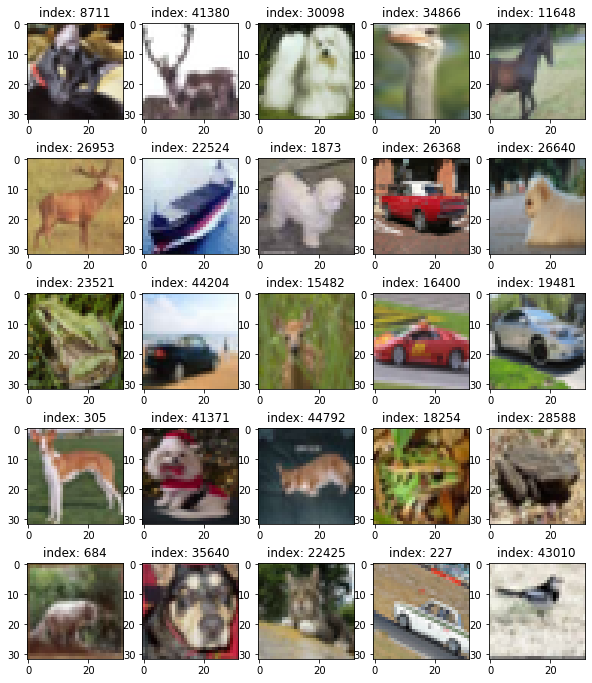

In [6]:
plt.figure(figsize=(10, 12))
for i in range(25):
  plt.subplot(5, 5, i+1)
  idx = np.random.randint(0, 50000)
  plt.imshow(image_denormalization(train_x[idx]).astype(np.uint8))
  plt.title(f'index: {idx}')

plt.show()

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 정의하기

In [9]:
def make_generator_model():

  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))

  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1, 1), padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
  
  return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
noise = tf.random.normal([1, 100], 2)
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [12]:
# noise_to_image(generated_image[0,:,:,0])
# image_denormalization(generated_image[0,:,:,0]).numpy().astype(np.uint8)
# train_x[0]
image_denormalization(generated_image[0,:,:,:]).numpy().astype(np.uint8)

array([[[126, 127, 127],
        [127, 128, 128],
        [128, 127, 128],
        ...,
        [129, 128, 126],
        [128, 127, 131],
        [128, 125, 126]],

       [[126, 125, 127],
        [127, 124, 125],
        [126, 124, 128],
        ...,
        [126, 130, 132],
        [125, 127, 126],
        [127, 127, 128]],

       [[126, 127, 126],
        [131, 125, 128],
        [127, 127, 129],
        ...,
        [131, 125, 127],
        [126, 124, 128],
        [125, 125, 128]],

       ...,

       [[127, 126, 126],
        [126, 126, 122],
        [126, 131, 130],
        ...,
        [122, 124, 127],
        [127, 133, 124],
        [125, 124, 132]],

       [[128, 127, 126],
        [128, 128, 124],
        [127, 126, 125],
        ...,
        [133, 127, 126],
        [128, 127, 133],
        [130, 126, 126]],

       [[126, 125, 127],
        [128, 125, 130],
        [129, 122, 128],
        ...,
        [127, 122, 124],
        [128, 125, 122],
        [127, 127, 130]]

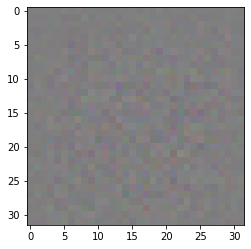

In [13]:
plt.imshow(noise_to_image(generated_image[0,:,:,:]))
# plt.colorbar()
plt.show()

## 판별자 구현하기

In [14]:
def make_discriminator_model():

  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[32,32,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1))

  return model



In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00016979]], dtype=float32)>

## 손실함수 구현하기

In [17]:
# 판별자의 output이 tanh나 sigmod같은 활성화함수를 거치지 않아 범위가 -1 ~ 1을 벗어나기 때문에
# from_logits=True로 설정해서 BinaryCrossentropy 함수 내부적으로 데이터를 정규화 한다
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

In [18]:
def generator_loss(fake_output):
  # generator는 fake_output이 1에 가까워지는 목적이므로 tf.ones_like(fake_output)을 이용
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
def discriminator_loss(real_output, fake_output):
  # discriminator는 진짜 이미지인 real_output은 1로, 생성된 이미지인 fake_output은 0으로 판단하는게 목적이므로 
  # real_loss 는 ones_like, fake_loss 는 zeros_like 이용
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [20]:
def discriminator_accuracy(real_output, fake_output):
  # reduce_mean : 특정 차원을 제거하고 평균을 구함
  # greater_equal : greater_equal(x1, x2)는 요소 단위로 (x1 >= x2)의 진리값을 반환
  real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
  # less : greater_equal(x, y)는 (x <y)의 진리 값을 요소 단위로 반환합니다.
  fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
  return real_accuracy, fake_accuracy

## 최적화함수

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 모델 훈련

In [31]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
  
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss, real_accuracy, fake_accuracy


In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

  predictions = model(sample_seeds, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    img = noise_to_image(predictions[i,:,:,:])
    plt.imshow(img)
    plt.axis("off")

  plt.savefig('/content/drive/MyDrive/aiffel/Exploration/ex13/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

  plt.show()

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 

def draw_train_history(history, epoch):
  plt.subplot(211)
  plt.plot(history['gen_loss'])
  plt.plot(history['disc_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('batch iters')
  plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

  plt.subplot(212)
  plt.plot(history['fake_accuracy'])
  plt.plot(history['real_accuracy'])
  plt.title('discriminator accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('batch iters')
  plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

  plt.savefig('/content/drive/MyDrive/aiffel/Exploration/ex13/training_history/train_history_{:04d}.png'.format(epoch))
  # plt.show()

In [26]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/Exploration/ex13/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
def train(dataset, epochs, save_every):
  start = time.time()
  history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

  for epoch in range(epochs):
    epoch_start = time.time()
    for it, image_batch in enumerate(dataset):
      gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
      history['gen_loss'].append(gen_loss)
      history['disc_loss'].append(disc_loss)
      history['real_accuracy'].append(real_accuracy)
      history["fake_accuracy"].append(fake_accuracy)

      if it % 50 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, it+1, seed)
        print('Epoch {} | iter {}'.format(epoch+1, it+1))
        print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

      if (epoch + 1) % save_every ==0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      
      display.clear_output(wait=True)
      generate_and_save_images(generator, epochs, it, seed)

      draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

Epoch 13 | iter 151
Time for epoch 13 : 92 sec


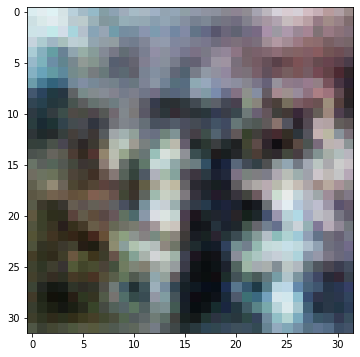

In [34]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/Exploration/ex13/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

KeyboardInterrupt: ignored

In [38]:
anim_file = '/content/drive/MyDrive/aiffel/Exploration/ex13/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aiffel/Exploration/ex13/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)

!ls -l /content/drive/MyDrive/aiffel/Exploration/ex13/fashion_mnist_dcgan.gif

-rw------- 1 root root 1 Sep  2 14:23 /content/drive/MyDrive/aiffel/Exploration/ex13/fashion_mnist_dcgan.gif
